In [2]:
# method: setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

plt.rcParams["figure.figsize"] = (10, 4)

TICKER = "AAPL"       # change to "MSFT" or "^VNINDEX"
LOOKBACK_DAYS = 365*2 # recent window for context
HORIZON = 7           # forecast steps
CONTEXT = 180         # training context size

In [3]:
# method: data acquisition (free EOD via yfinance)
def fetch_series_yf(ticker: str, lookback_days: int = 365):
    df = yf.download(ticker, period="5y", interval="1d").reset_index()
    if df.empty:
        raise ValueError(f"no data from yfinance for {ticker}")
    df = df.rename(columns={"Date": "date", "Close": "close"})
    df = df[["date", "close"]].dropna().sort_values("date").reset_index(drop=True)
    if lookback_days:
        df = df.tail(lookback_days).reset_index(drop=True)
    return df

df = fetch_series_yf(TICKER, LOOKBACK_DAYS)
y = df["close"].to_numpy(float)
series = y[-CONTEXT:] if len(y) > CONTEXT else y

print(f"{TICKER}: {df['date'].min().date()} → {df['date'].max().date()} | rows={len(df)} | ctx={len(series)}")
df.tail(3)

/var/folders/3p/54rhmhtx5ssbx40cgtfvc6740000gn/T/ipykernel_13244/936707622.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="5y", interval="1d").reset_index()
[*********************100%***********************]  1 of 1 completed

AAPL: 2022-11-14 → 2025-10-13 | rows=730 | ctx=180


Price,date,close
Ticker,,AAPL
727,2025-10-09,254.039993
728,2025-10-10,245.270004
729,2025-10-13,247.660004


In [4]:
# method: minimal data readiness
def report(df: pd.DataFrame):
    return {
        "rows": len(df),
        "date_is_dt": pd.api.types.is_datetime64_any_dtype(df["date"]),
        "close_is_num": pd.api.types.is_numeric_dtype(df["close"]),
        "dup_dates": int(df["date"].duplicated().sum()),
        "na_close": int(df["close"].isna().sum()),
        "sorted": df["date"].is_monotonic_increasing,
        "min": str(df["date"].min()),
        "max": str(df["date"].max())
    }

r = report(df)
print(r)

{'rows': 730, 'date_is_dt': True, 'close_is_num': False, 'dup_dates': 0, 'na_close': 0, 'sorted': True, 'min': '2022-11-14 00:00:00', 'max': '2025-10-13 00:00:00'}


/var/folders/3p/54rhmhtx5ssbx40cgtfvc6740000gn/T/ipykernel_13244/2196764379.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  "na_close": int(df["close"].isna().sum()),


In [5]:
# method: baselines + classical model 
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def naive_last(train, h):
    return np.array([train[-1]] * h, dtype=float)

def moving_average(train, h, window=10):
    w = train[-window:] if len(train) >= window else train
    return np.array([float(np.mean(w))] * h, dtype=float)

def forecast_holtwinters(train, h):
    # additive trend, no seasonality for daily EOD; tweak if cần (trend='mul', seasonal='add', seasonal_periods=?)
    model = ExponentialSmoothing(train, trend='add', seasonal=None)
    fit = model.fit(optimized=True, use_brute=True)
    fc = fit.forecast(h)
    return np.asarray(fc, dtype=float)

pred_naive = naive_last(series, HORIZON)
pred_ma10  = moving_average(series, HORIZON, 10)

try:
    pred_hw = forecast_holtwinters(series, HORIZON)
except Exception as e:
    print("holt-winters failed:", e)
    pred_hw = pred_ma10

print("baseline samples:", pred_naive[0], pred_ma10[0], pred_hw[0])


baseline samples: [247.66000366] 254.34300079345704 247.76398759413073


In [6]:
# method: pretrained AI (offline) — Chronos-T5 tiny; fallback to ARIMA on error
USE_CHRONOS = True
pred_chronos = None

if USE_CHRONOS:
    try:
        from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
        import torch

        model_id = "amazon/chronos-t5-tiny"
        tok = AutoTokenizer.from_pretrained(model_id)
        mdl = AutoModelForSeq2SeqLM.from_pretrained(model_id)

        # normalize to z-score for stable generation
        x = (series - series.mean()) / (series.std() + 1e-8)
        ts_str = " ".join(f"{v:.6f}" for v in x.astype(np.float32))

        inputs = tok(ts_str, return_tensors="pt")
        with torch.no_grad():
            out = mdl.generate(
                **inputs,
                max_length=inputs["input_ids"].shape[1] + HORIZON,
                do_sample=True, top_k=50, top_p=0.9, temperature=0.8
            )

        out_text = tok.batch_decode(out, skip_special_tokens=True)[0]
        vals = [float(s) for s in out_text.strip().split()[-HORIZON:]]
        pred_chronos = np.array(vals) * (series.std() + 1e-8) + series.mean()
        print("chronos ok:", pred_chronos[:3], "…")
    except Exception as e:
        print("chronos failed (using arima):", e)
        pred_chronos = None


/Users/sofnb25/Documents/MS34/MSA34 - Python/Project/demo_python_basic/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


chronos failed (using arima): Converting from SentencePiece and Tiktoken failed, if a converter for SentencePiece is available, provide a model path with a SentencePiece tokenizer.model file.Currently available slow->fast converters: ['AlbertTokenizer', 'BartTokenizer', 'BarthezTokenizer', 'BertTokenizer', 'BigBirdTokenizer', 'BlenderbotTokenizer', 'CamembertTokenizer', 'CLIPTokenizer', 'CodeGenTokenizer', 'ConvBertTokenizer', 'DebertaTokenizer', 'DebertaV2Tokenizer', 'DistilBertTokenizer', 'DPRReaderTokenizer', 'DPRQuestionEncoderTokenizer', 'DPRContextEncoderTokenizer', 'ElectraTokenizer', 'FNetTokenizer', 'FunnelTokenizer', 'GPT2Tokenizer', 'HerbertTokenizer', 'LayoutLMTokenizer', 'LayoutLMv2Tokenizer', 'LayoutLMv3Tokenizer', 'LayoutXLMTokenizer', 'LongformerTokenizer', 'LEDTokenizer', 'LxmertTokenizer', 'MarkupLMTokenizer', 'MBartTokenizer', 'MBart50Tokenizer', 'MPNetTokenizer', 'MobileBertTokenizer', 'MvpTokenizer', 'NllbTokenizer', 'OpenAIGPTTokenizer', 'PegasusTokenizer', 'Qwen2

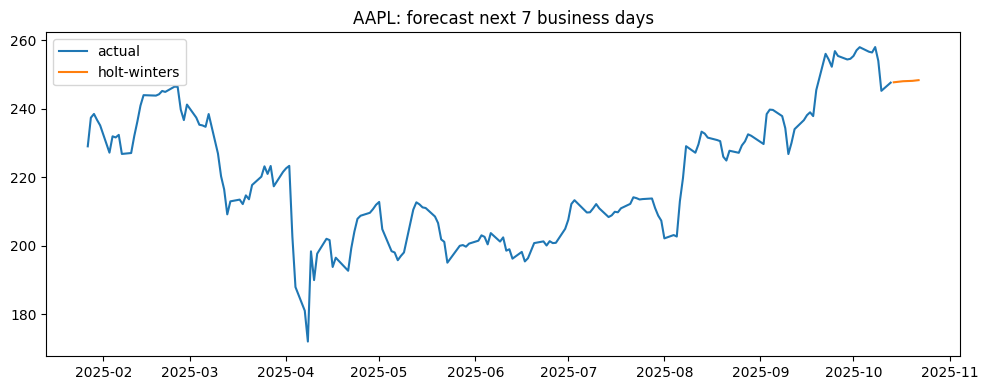

In [7]:
# method: pick forecast & visualize
pred = pred_chronos if pred_chronos is not None else pred_hw

last_date = pd.to_datetime(df["date"].iloc[-1])

# create business-day index for the next HORIZON days
# note: older/newer pandas may not support `closed`; slice off the start instead
future_idx = pd.bdate_range(start=last_date, periods=HORIZON + 1)[1:]

import matplotlib.pyplot as plt
plt.plot(df["date"].tail(CONTEXT), series, label="actual")
plt.plot(future_idx, pred, label=("chronos" if pred_chronos is not None else "holt-winters"))
plt.title(f"{TICKER}: forecast next {HORIZON} business days")
plt.legend(); plt.tight_layout(); plt.show()

In [8]:
def mae(a,b): return float(np.mean(np.abs(a-b)))
def rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))

if len(series) > HORIZON + 30:
    train, test = series[:-HORIZON], series[-HORIZON:]
    preds = {
        "naive": naive_last(train, HORIZON),
        "ma10":  moving_average(train, HORIZON, 10)
    }
    try:
        preds["holtwinters"] = forecast_holtwinters(train, HORIZON)
    except:
        preds["holtwinters"] = preds["ma10"]

    if pred_chronos is not None:
        preds["chronos"] = pred_chronos  # từ full-context; so sánh tham khảo

    for name, p in preds.items():
        print(f"{name:11s} | MAE={mae(test,p):.4f} | RMSE={rmse(test,p):.4f}")
else:
    print("not enough points for holdout check")

naive       | MAE=3.9043 | RMSE=5.8817
ma10        | MAE=4.0073 | RMSE=4.8347
holtwinters | MAE=4.2089 | RMSE=6.2887


In [9]:
# method: adapter for ai_module
def build_result_json(symbol, hist, pred):
    last = float(hist[-1])
    avgp = float(np.mean(pred))
    signal = "BUY" if avgp > last else ("SELL" if avgp < last else "HOLD")
    trend = "Uptrend" if avgp > last else ("Downtrend" if avgp < last else "Sideways")
    inds = {"RSI14": 50, "SMA7": float(np.mean(hist[-7:])), "SMA30": float(np.mean(hist[-30:]))}
    return {
        "symbol": symbol,
        "trend": trend,
        "signal": signal,
        "technical_indicators": inds,
        "reason": f"avg_pred={avgp:.2f} vs last={last:.2f}"
    }

result_json = build_result_json(TICKER, series, pred)
result_json

/var/folders/3p/54rhmhtx5ssbx40cgtfvc6740000gn/T/ipykernel_13244/3094880547.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last = float(hist[-1])


{'symbol': 'AAPL',
 'trend': 'Uptrend',
 'signal': 'BUY',
 'technical_indicators': {'RSI14': 50,
  'SMA7': 253.74571446010046,
  'SMA30': 246.0336664835612},
 'reason': 'avg_pred=248.08 vs last=247.66'}

In [10]:
# --- cell 9: generate AI advice (with import path fix) ---

import sys
from pathlib import Path

# ensure project root (where ai_module.py is located) is in sys.path
ROOT_DIR = Path.cwd().parents[0]   # from /notebooks → go up one level
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))

try:
    from ai_module import get_ai_advice, get_ai_confidence_score, get_market_sentiment

    advice = get_ai_advice(result_json)
    conf = get_ai_confidence_score(result_json)
    senti = get_market_sentiment(TICKER, result_json)

    print("=== AI Advice ===")
    print(advice)
    print("\nConfidence:", round(conf, 3))
    print("Sentiment :", senti)

except ModuleNotFoundError as e:
    print("⚠️ Could not import ai_module.py — please ensure this file exists in the project root.")
    print("Error:", e)

except Exception as e:
    print("⚠️ Runtime error while generating AI advice:", e)

=== AI Advice ===
Tín hiệu mua xuất hiện cho AAPL với các chỉ báo hỗ trợ. Các yếu tố hỗ trợ: Xu hướng tăng rõ ràng, RSI trong vùng an toàn, SMA ngắn hạn vượt SMA dài hạn. Cảnh báo: Thị trường biến động, cần theo dõi sát sao. Nên đặt stop-loss để bảo vệ vốn.

Confidence: 1.0
Sentiment : Bullish


In [11]:
# --- cell 10: save forecast artifacts ---
import json
from pathlib import Path

art_dir = Path("artifacts"); art_dir.mkdir(parents=True, exist_ok=True)

# next business days after last_date
future_idx = pd.bdate_range(start=pd.to_datetime(df["date"].iloc[-1]), periods=HORIZON + 1)[1:]

# compute ±1 std range for visualization
pred_std = np.std(pred)
pred_min = pred - pred_std
pred_max = pred + pred_std

forecast_df = pd.DataFrame({
    "date": future_idx,
    "forecast": pred,
    "forecast_min": pred_min,
    "forecast_max": pred_max
})

csv_path = art_dir / f"{TICKER.lower()}_forecast_{HORIZON}d.csv"
json_path = art_dir / f"{TICKER.lower()}_result.json"

forecast_df.to_csv(csv_path, index=False)

# add min/max summary to JSON
result_json["forecast_summary"] = {
    "mean_pred": float(np.mean(pred)),
    "min_pred": float(np.min(pred_min)),
    "max_pred": float(np.max(pred_max)),
    "std": float(pred_std)
}

with open(json_path, "w") as f:
    json.dump(result_json, f, ensure_ascii=False, indent=2)

print("saved:")
print(" -", csv_path)
print(" -", json_path)
print("\nForecast summary:", result_json["forecast_summary"])

saved:
 - artifacts/aapl_forecast_7d.csv
 - artifacts/aapl_result.json

Forecast summary: {'mean_pred': 248.07593949238756, 'min_pred': 247.5560196619595, 'max_pred': 248.59585932281558, 'std': 0.2079679321712149}


In [12]:
# --- cell 11: quick baseline comparison ---
def mae(a, b): return float(np.mean(np.abs(a - b)))
def rmse(a, b): return float(np.sqrt(np.mean((a - b) ** 2)))

if len(series) > HORIZON + 30:
    train, test = series[:-HORIZON], series[-HORIZON:]

    # baselines
    bench = {
        "naive":  np.array([train[-1]] * HORIZON),
        "ma10":   np.array([np.mean(train[-10:])] * HORIZON),
        "holt-winters": forecast_holtwinters(train, HORIZON)
    }

    rows = []
    for name, p in bench.items():
        rows.append({"model": name, "MAE": mae(test, p), "RMSE": rmse(test, p)})

    comp = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
    display(comp)
else:
    print("Not enough data for holdout comparison.")

,model,MAE,RMSE
0,ma10,4.007286,4.834737
1,naive,3.904284,5.881712
2,holt-winters,4.208883,6.288739
